<a href="https://colab.research.google.com/github/DiploDatos/AnalisisYCuracion/blob/master/08_Encodings_para_texto_y_LDA_%5BOpcional%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Encodings for text and LDA

In this notebook, we will use the combined melbourn and airbnd dataframe, which contains Melbourne property sales data from [this Kaggle competition](https://www. kaggle.com/dansbecker/melbourne-housing-snapshot), to which a column with neighborhood descriptions extracted from [a dataset of scrapings](https://www.kaggle.com/tylerx/melbourne-snapshot) was added. airbnb-open-data?select=cleansed_listings_dec18.csv) from AirBnB listings.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas

import seaborn
seaborn.set_context('talk')

In [2]:
# This allows us to print more information per column
pandas.set_option('display.max_colwidth', 500)

In [3]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_extended_neighborhood_overview.csv')
melb_df.sample(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,closest_airbnb_neighborhood_overview
12131,Preston,5 Toolangi Gr,3,h,1045000.0,S,RW,29/07/2017,8.4,3072.0,...,2.0,520.0,NaN,NaN,Darebin,-37.75371,145.01964,Northern Metropolitan,14577.0,"Thornbury / Preston are cute and edgy suburbs in Melbourne's north, with an easy way of life, heaps of green spaces, buzzing Preston Market, bike paths, creative cafes, food truck parks and a homely shopping strip (High Street), where you can pick up your daily deli goods and browse some unique boutiques. Do’s and don’s all written up in our manual, available at the house!\nOur townhouse is located in a quiet street in Thornbury, however is is close to transport & very close to great restau..."
3850,Malvern East,69 Beaver St,4,h,2123000.0,S,Jellis,12/11/2016,11.2,3145.0,...,2.0,412.0,254.0,1930.0,Stonnington,-37.87070,145.04820,Southern Metropolitan,8801.0,"Beautifully restored federation homes line the leafy streets of this affluent neighbourhood. Just 8 kilometres south-east of the city, Malvern encompasses several significant heritage buildings, as well as many clean and green spaces, including the very popular Central Park. Neighbouring Armadale, Caulfield and Hawthorn, this prized pocket offers access to some of Melbournes best shopping and dining precincts.\n\n\nIt is a quiet, leafy, lovely neighbourhood.\n\nThe area is, in our opinions..."
2875,Glenroy,15 Stanley St,3,h,980000.0,SP,Brad,4/03/2017,13.0,3046.0,...,3.0,1029.0,136.0,1950.0,Moreland,-37.71150,144.91470,Northern Metropolitan,8870.0,"\nQuiet and very convenient location.\n\nThe neighbourhood is quiet, safe and accessible to all needs of a guest. Here, you will be able to relax, as well as have an adventure in the neighbourhood itself or in the city which is only 12km away (10 minute drive). The airport is only 9kms . A short walk to the train station, supermarket, chemist, cafes and many other stores.\n\n\n\nLocation and transport: We have 10 mind to Glenroy train station, which gets you into the CBD in 25 minutes. Other..."


## Exploring free text

Unstructured data, such as free text or images, have specific methods to be able to analyze them. In this notebook we will try to understand what kind of information neighborhood descriptions give us, and if it can be useful in our price prediction task.

It is useful to know how much text we have per instance, to start estimating the amount of information represented and some characteristics of the documents. For example: it is not the same to analyze Tweets as it is to analyze Wikipedia documents.

/user/nocampo/home/miniconda3/envs/sald/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of number of characters for neighborhood reviews')

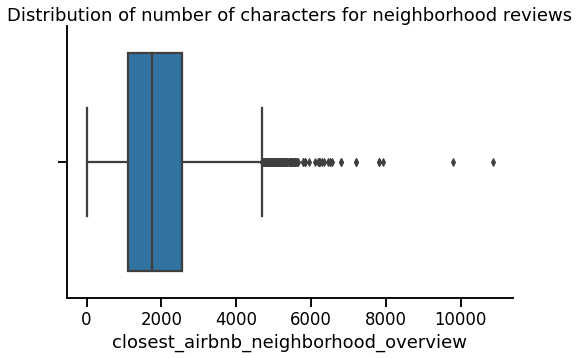

In [4]:
plt.figure(figsize=(8, 5))
seaborn.boxplot(melb_df.closest_airbnb_neighborhood_overview.apply(len))
seaborn.despine()
plt.title("Distribution of number of characters for neighborhood reviews")

## Word frequency analysis

### Word Clouds by CouncilArea

A good visual representation to understand what a text is about are word clouds.

In [5]:
def sample_text_from_col(df, n=100,
                         text_col='closest_airbnb_neighborhood_overview'):
  """Extract a sample of text from column"""
  if n > len(df):
    n = len(df)
  return '\n'.join(df.sample(n)[text_col].values)

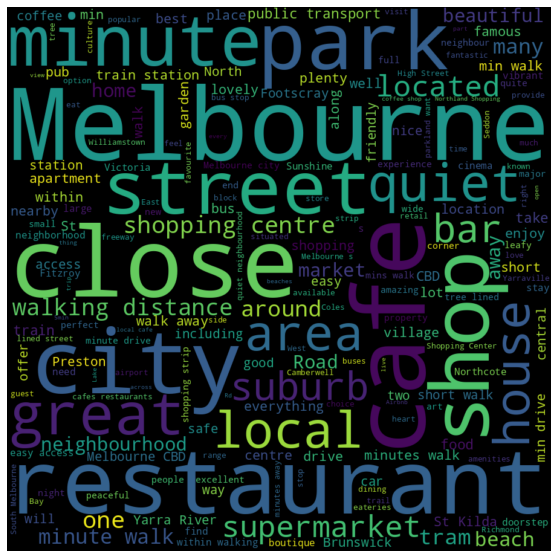

In [6]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text_sample = sample_text_from_col(melb_df)
wc = WordCloud(width=900, height=900, max_font_size=200).generate(text_sample)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

We can now create word clouds for the CouncilArea descriptions

In [7]:
unique_council_areas = melb_df.CouncilArea.unique()
text_samples_for_areas = {
    area: sample_text_from_col(melb_df[melb_df.CouncilArea == area])
    for area in unique_council_areas
    if isinstance(area, str)
}
list(text_samples_for_areas.keys())

['Yarra',
 'Moonee Valley',
 'Port Phillip',
 'Darebin',
 'Hobsons Bay',
 'Stonnington',
 'Boroondara',
 'Monash',
 'Glen Eira',
 'Whitehorse',
 'Maribyrnong',
 'Bayside',
 'Moreland',
 'Manningham',
 'Banyule',
 'Melbourne',
 'Kingston',
 'Brimbank',
 'Hume',
 'Knox',
 'Maroondah',
 'Casey',
 'Melton',
 'Greater Dandenong',
 'Nillumbik',
 'Whittlesea',
 'Frankston',
 'Macedon Ranges',
 'Yarra Ranges',
 'Wyndham',
 'Cardinia',
 'Unavailable',
 'Moorabool']

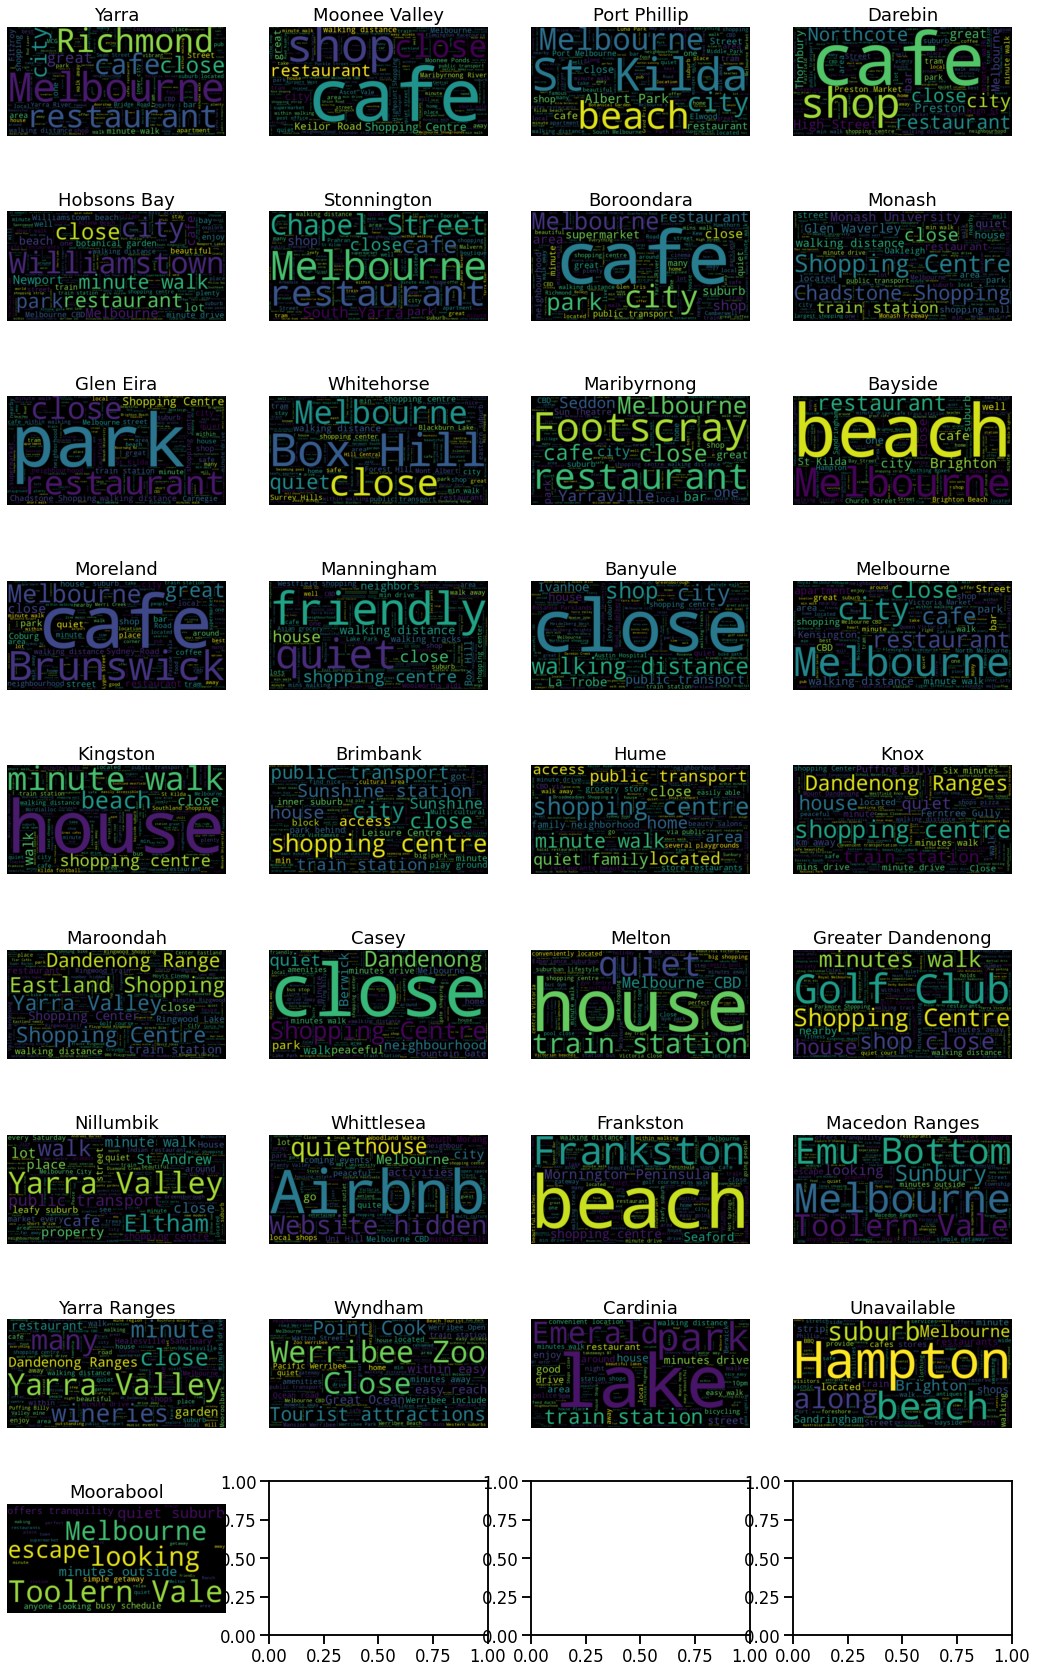

In [8]:
import math
# Create general layout
n_cols = 4
n_rows = math.ceil(len(text_samples_for_areas) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 30))
for i, (area, text_sample) in enumerate(text_samples_for_areas.items()):
  wc = WordCloud(width=600, height=300, max_font_size=200)\
      .generate(text_sample)
  row = math.floor(i / n_cols)
  col = i % n_cols
  ax = axs[row, col]
  ax.imshow(wc, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(area)

## Encoding variables with free text

Although word clouds are very intuitive, we cannot use them to perform numerical analysis. In the same way as categorical data, textual data needs to be encoded in vectors.

In this mini-introduction we will use an encoding of *bag of words* or bag-of-words in English. Sean:
1. $W$ is the set of words called *vocabulary*, and let $M = |W|$ be its size. That is, there are $M$ different words in our documents.
2. $w_i \in W $ the word number $i$ of the vocabulary.

Using scikit-learn's `CountVectorizer` class, the document is cast to a vector $v \in \mathbb{R}^{M}$ where each column $i$ is filled with the number of times each word $w_i$ occur in the document.

To avoid an explosion of dimensions, we will limit the size of the vocabulary to only the most frequent words. In addition to this, the most frequent words of a language, such as "he", "of", are very uninformative. They are called *stopwords*. For this reason, they are generally ignored in these types of representations.

Note: This representation is one of the simplest to obtain, however, there are other more suitable projections.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
vocab_size = 500  ## Only 500 most frequent words
vectorizer = CountVectorizer(max_features=vocab_size, stop_words='english')
tokens = vectorizer.fit_transform(melb_df.closest_airbnb_neighborhood_overview)

In [11]:
vectorizer.get_feature_names()[:10]

/user/nocampo/home/miniconda3/envs/sald/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['10', '11', '12', '15', '1km', '20', '25', '30', '5km', 'access']

In [12]:
tokens.shape

(13580, 500)

Podemos ver la frecuencia de cada palabra

In [13]:
word_frequencies = pandas.DataFrame(
    data={'frequency': tokens.sum(axis=0).flatten().tolist()[0],
                                     'tokens': vectorizer.get_feature_names()})
word_frequencies.sort_values('frequency')

,frequency,tokens
492,916,woolworth
113,916,cuisine
132,917,doncaster
94,917,clothing
466,919,use
...,...,...
65,29747,cafes
394,30963,shopping
373,31122,restaurants
479,39023,walk


## Dimensionality reduction

The vectors that represent each of our comments do not help us to understand the data, because we cannot think in hundreds of dimensions at the same time. They are too *counterintuitive*.

We can try to apply a method like PCA to reduce the dimensionality of vectors, but this will not return vectors that we can read or understand.

Fortunately, there are ways to transform them into representations that are more *human-friendly*.

[LDA](https://scikit-learn.org/stable/modules/decomposition.html?highlight=lda#latent-dirichlet-allocation-lda) or Latent Dirichlet Allocation is a model that assumes that each text talks about a topic or unknown *topic*.

When it is trained, it finds groups of words (vectors) that correspond to the topics that would best explain the data.

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(tokens)

LatentDirichletAllocation(n_components=5, random_state=0)

In [16]:
feature_names = vectorizer.get_feature_names()
feature_names[:3]

/user/nocampo/home/miniconda3/envs/sald/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['10', '11', '12']

In [17]:
def plot_top_words(model, feature_names, n_top_words=10, title=''):
    n_cols = 2
    n_rows = math.ceil(model.n_components / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

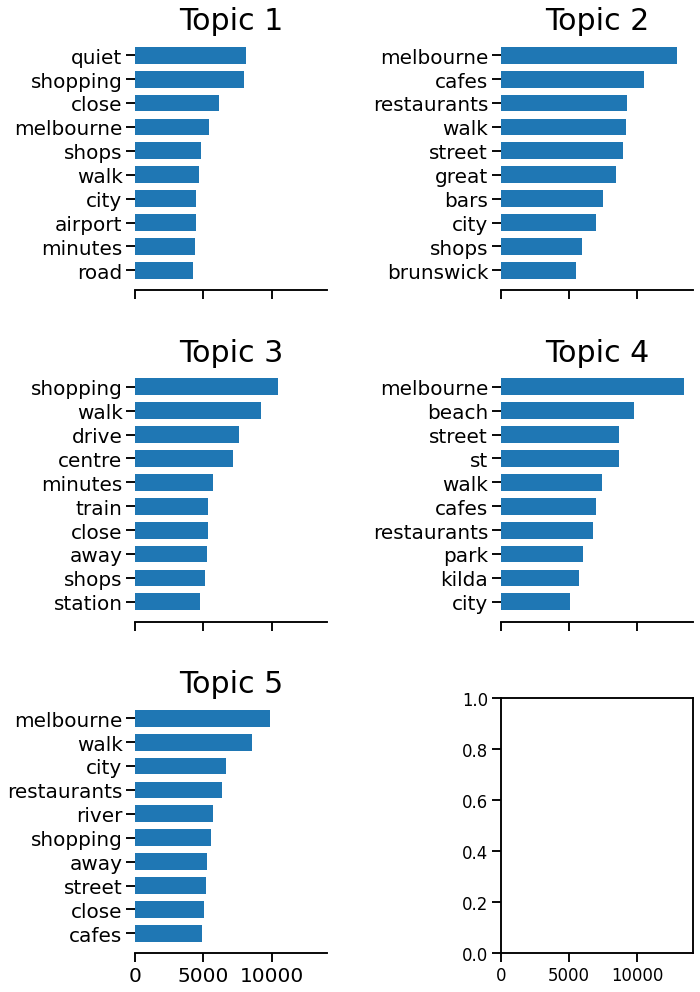

In [18]:
plot_top_words(lda, feature_names)

Now we can use the model to determine what is the probability that a text will be generated by that topic. That is, "how much of topic X does the document talk about?"

In [19]:
lda_columns = ['topic{}'.format(i) for i in range(lda.n_components)]
melb_df[lda_columns] = lda.transform(tokens)

In [20]:
melb_df[['closest_airbnb_neighborhood_overview'] + lda_columns].sample()

,closest_airbnb_neighborhood_overview,topic0,topic1,topic2,topic3,topic4
3605,"\nQuiet leafy neighbourhood away from the hustle and bustle of city.\nIt is walking distance to the Kew Junction shops, cafes and restaurants. The Kew Recreation Centre is at the top of the street along with bus and tram stops on each side of the street. The Yarra river and parklands are a beautiful 10 minute walk away, and within the area you can do bush walking, hire row boats and play golf. We have wonderful providores, restaurants and cafes. I recommend Leo's fine food, Toscanos, Laurent...",0.233894,0.002123,0.185091,0.00211,0.576783


Now we can see the correlations between the topics and the rest of the variables in our data set. We can see that there is a certain correlation between the first topic with some of the possible values for CouncilArea

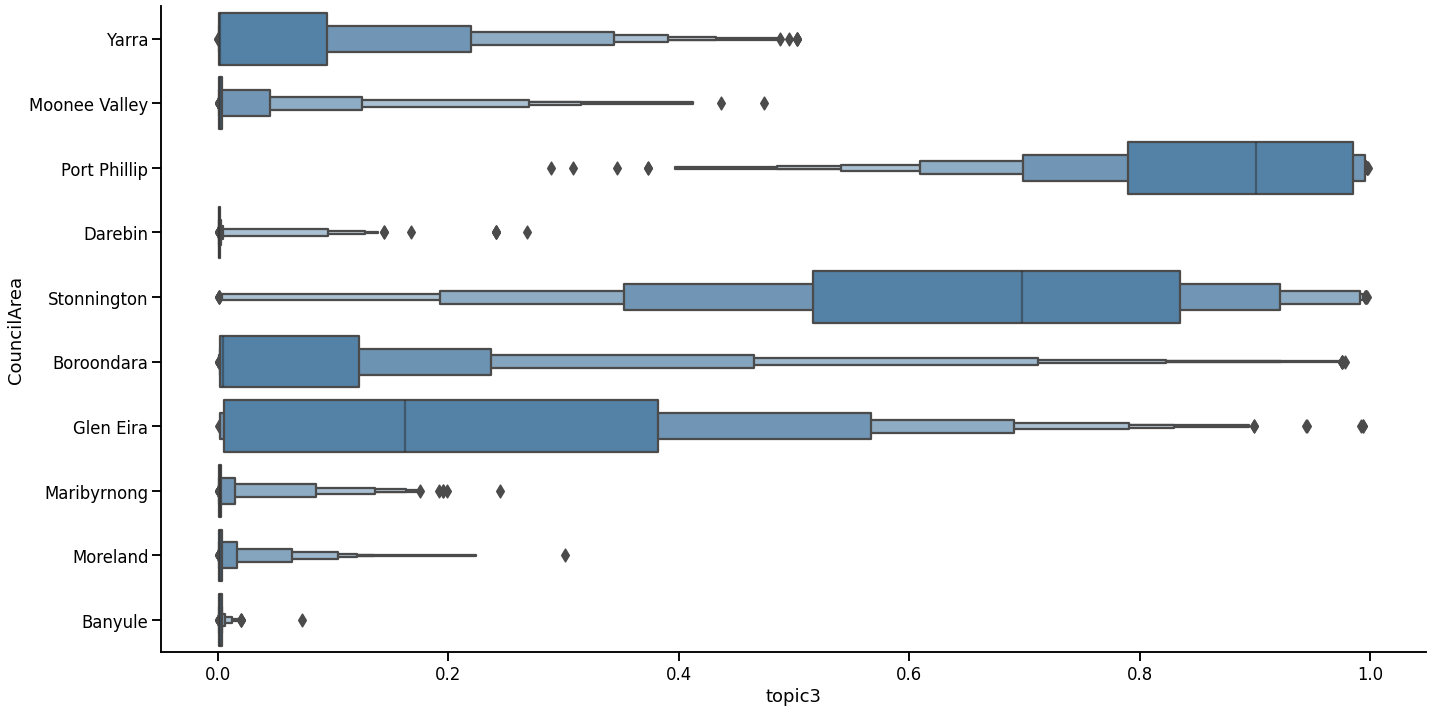

In [21]:
most_common_areas = melb_df.CouncilArea.value_counts()[:10].index
seaborn.catplot(data=melb_df[melb_df.CouncilArea.isin(most_common_areas)],
                x='topic3', y='CouncilArea', kind='boxen',
                height=10, aspect=2, color='steelblue')

Does it help us to better estimate the price of a property? If we plot the price distribution for each topic (taking only the most likely topic for each document), we don't see much variability.

In [22]:
melb_df['most_likely_topic'] = melb_df[lda_columns].values.argmax(axis=1)
melb_df[lda_columns + ['most_likely_topic']].head()

,topic0,topic1,topic2,topic3,topic4,most_likely_topic
0,0.000458,0.239827,0.048415,0.000457,0.710844,4
1,0.000307,0.477759,0.000308,0.044790,0.476835,1
2,0.000295,0.594901,0.000295,0.082541,0.321968,1
3,0.025602,0.191831,0.105826,0.000408,0.676333,4
4,0.000379,0.515925,0.000381,0.000382,0.482933,1


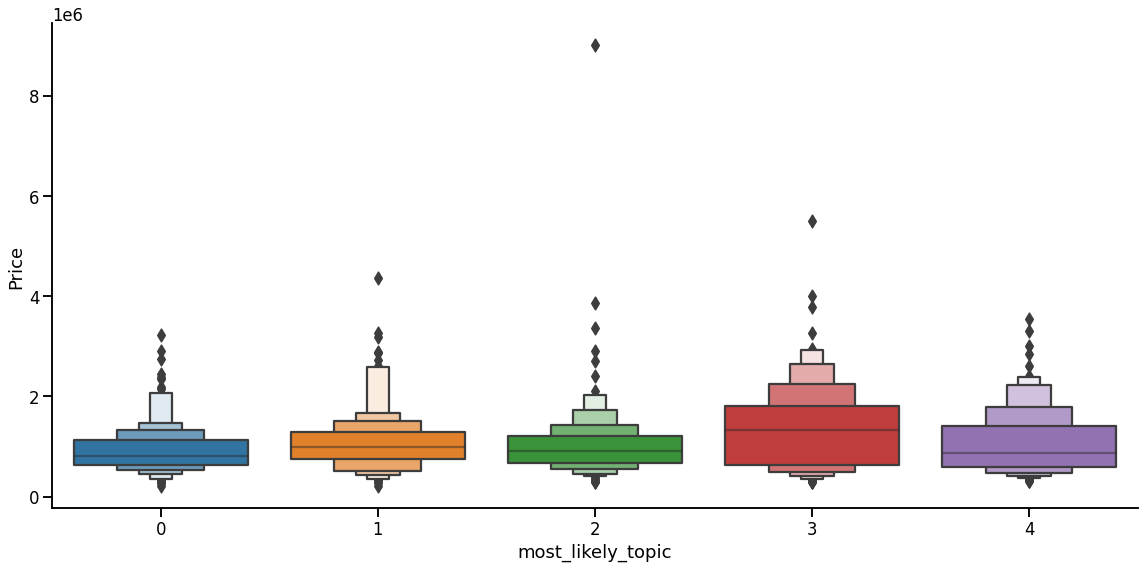

In [23]:
seaborn.catplot(data=melb_df.sample(1000),
                x='most_likely_topic', y='Price',# hue='Type',
                kind='boxen',
                height=8, aspect=2)